# Home_task_3

# <center>Домашнее задание № 3 (демо). <br>Деревья решений в игрушечной задаче и на данных Adult репозитория UCI

**В задании Вам предлагается разобраться с тем, как работает дерево решений, на игрушечном примере, затем обучить и настроить деревья и (при желании) случайный лес в задаче классификации на данных Adult репозитория UCI. Ответьте на все вопросы в этой тетрадке и заполните ответы в [гугл-форме](https://docs.google.com/forms/d/1bC3jNPH7XZUty_DaIvt0fPrsiS8YFkcpeBKHPSG0hw0/edit).**

Подключаем необходимые библиотеки

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Часть 1. Игрушечный набор данных "девушка в баре"

**Цель –  "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.**

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**

![png](https://nbviewer.org/github/Yorko/mlcourse.ai/blob/main/img/toy_data.png)

### Создание набора данных

In [2]:
# Создание датафрейма с dummy variables

def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот

def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

**Обучающая выборка**

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


**Тестовая выборка**

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот

y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Уровень_красноречия_средний,Алкоголь_в_напитке_нет,Потраченные_деньги_мало,Внешность_приятная,Потраченные_деньги_много,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий
0,0,0,0,1,1,1,0,1
1,0,0,1,1,0,1,0,0
2,1,1,0,1,1,0,0,0
3,1,1,1,0,0,0,1,0
4,0,0,0,0,1,1,1,0
5,0,0,0,0,1,1,1,1
6,1,0,0,1,1,1,0,0


In [7]:
df_test

,Уровень_красноречия_средний,Алкоголь_в_напитке_нет,Потраченные_деньги_мало,Внешность_приятная,Потраченные_деньги_много,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий
0,1,1,0,1,1,0,0,0
1,0,0,1,1,0,1,0,1
2,1,0,0,0,1,1,1,0


**Постройте от руки (или в графическом редакторе) дерево решений для этого набора данных. Дополнительно (для желающих) – можете сделать отрисовку дерева и написать код для построения всего дерева.**

<font color='red'>Вопрос 1.</font> Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

<font color='red'>Вопрос 2. </font> Рассмотрим разбиение обучающей выборки по признаку "Внешность\_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации  при данном разбиении (IG)? 

Ответим на первый вопрос.

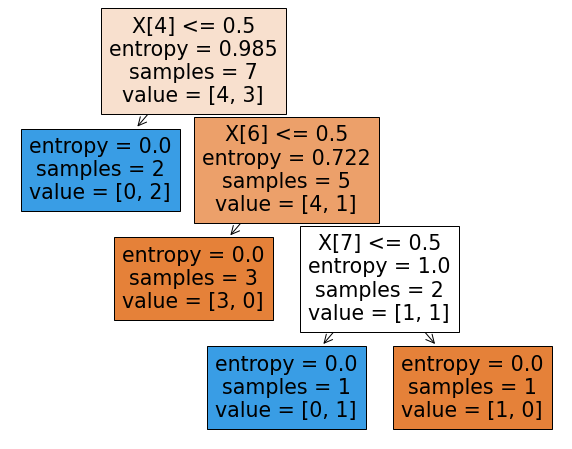

In [8]:
from sklearn.tree import plot_tree # Подгрузим функцию для отрисовки

tree_1 = DecisionTreeClassifier(criterion='entropy')
tree_1.fit(df_train, y)

plot_tree(tree_1, filled=True); # Отсюда видно, что энтропия равна 0.985

Теперь ответим на второй вопрос.

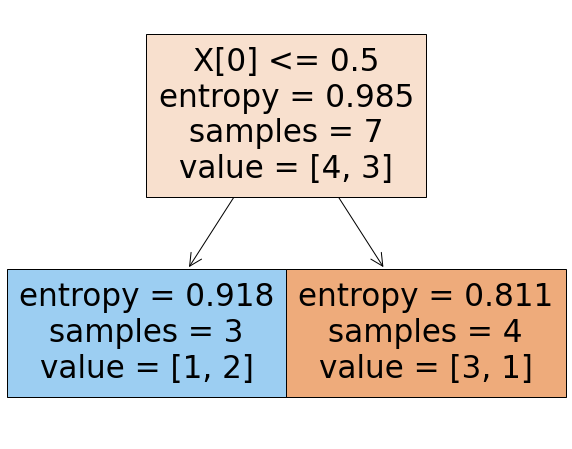

In [9]:
tree_2 = DecisionTreeClassifier(criterion='entropy')
tree_2.fit(df_train[['Внешность_приятная']], y)

plot_tree(tree_2, filled=True); # Отсюда легко видеть энтропию, а также IG = 0.985 - 3/7 * 0.918 - 4/7 * 0.811 = 0.128 (примерно)

**Постройте с помощью `sklearn` дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.**

In [10]:
from sklearn.tree import DecisionTreeClassifier # Подгрузили классификатор

clf_tree = DecisionTreeClassifier() # Создали дерево
clf_tree.fit(df_train, y); # Обучили на обучающей выборке (df_train, y)

**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

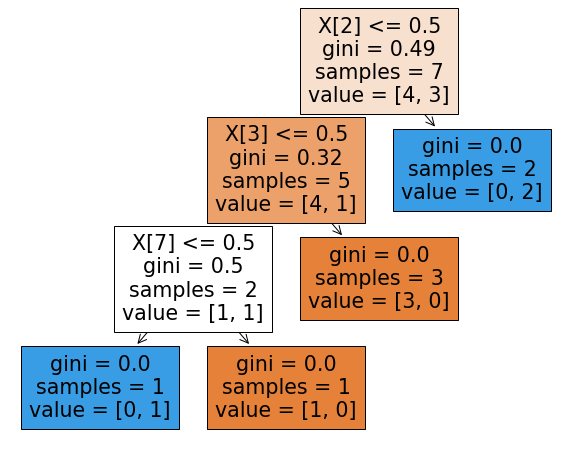

In [11]:
from sklearn.tree import plot_tree # Подгрузим функцию для отрисовки

plot_tree(clf_tree, filled=True);

## Часть 2. Функции для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [12]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![png](https://nbviewer.org/github/Yorko/mlcourse.ai/blob/main/img/decision_tree3.png)

Дальше пусть шарики разбиваются на 2 группы
![png](https://nbviewer.org/github/Yorko/mlcourse.ai/blob/main/img/decision_tree4.png)

In [13]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [14]:
def entropy(a_list):
    probs = (pd.DataFrame(a_list, columns=['class']) \
                 .groupby('class').value_counts() / len(a_list)) # Здесь посчитаем вероятности
    return probs.apply(lambda x: -x*np.log2(x)).sum() # А здесь выведем энтропию Шеннона

Проверка

In [15]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


<font color='red'>Вопрос 3.</font> Чему равна энтропия состояния, заданного списком `balls_left`?

<font color='red'>Вопрос 4.</font> Чему равна энтропия игральной кости с несмещенным центром тяжести?

In [16]:
# расчет прироста информации

def information_gain(root, left, right):
    return entropy(root) - len(left)/len(root) * entropy(left) - len(right)/len(root) * entropy(right)

<font color='red'>Вопрос 5.  </font> Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [17]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

## Часть 3. Набор данных "Adult"

**Описание набора:**

**[Набор](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) данных UCI Adult** (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [18]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

data_train = pd.read_csv(DATA_PATH + "adult_train.csv", sep=";")

In [19]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [20]:
data_test = pd.read_csv(DATA_PATH + "adult_test.csv", sep=";")

In [21]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [22]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[
    (data_test["Target"] == " >50K.") | (data_test["Target"] == " <=50K.")
]

# перекодируем target в числовое поле
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1

**Первичный анализ данных.**

In [23]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

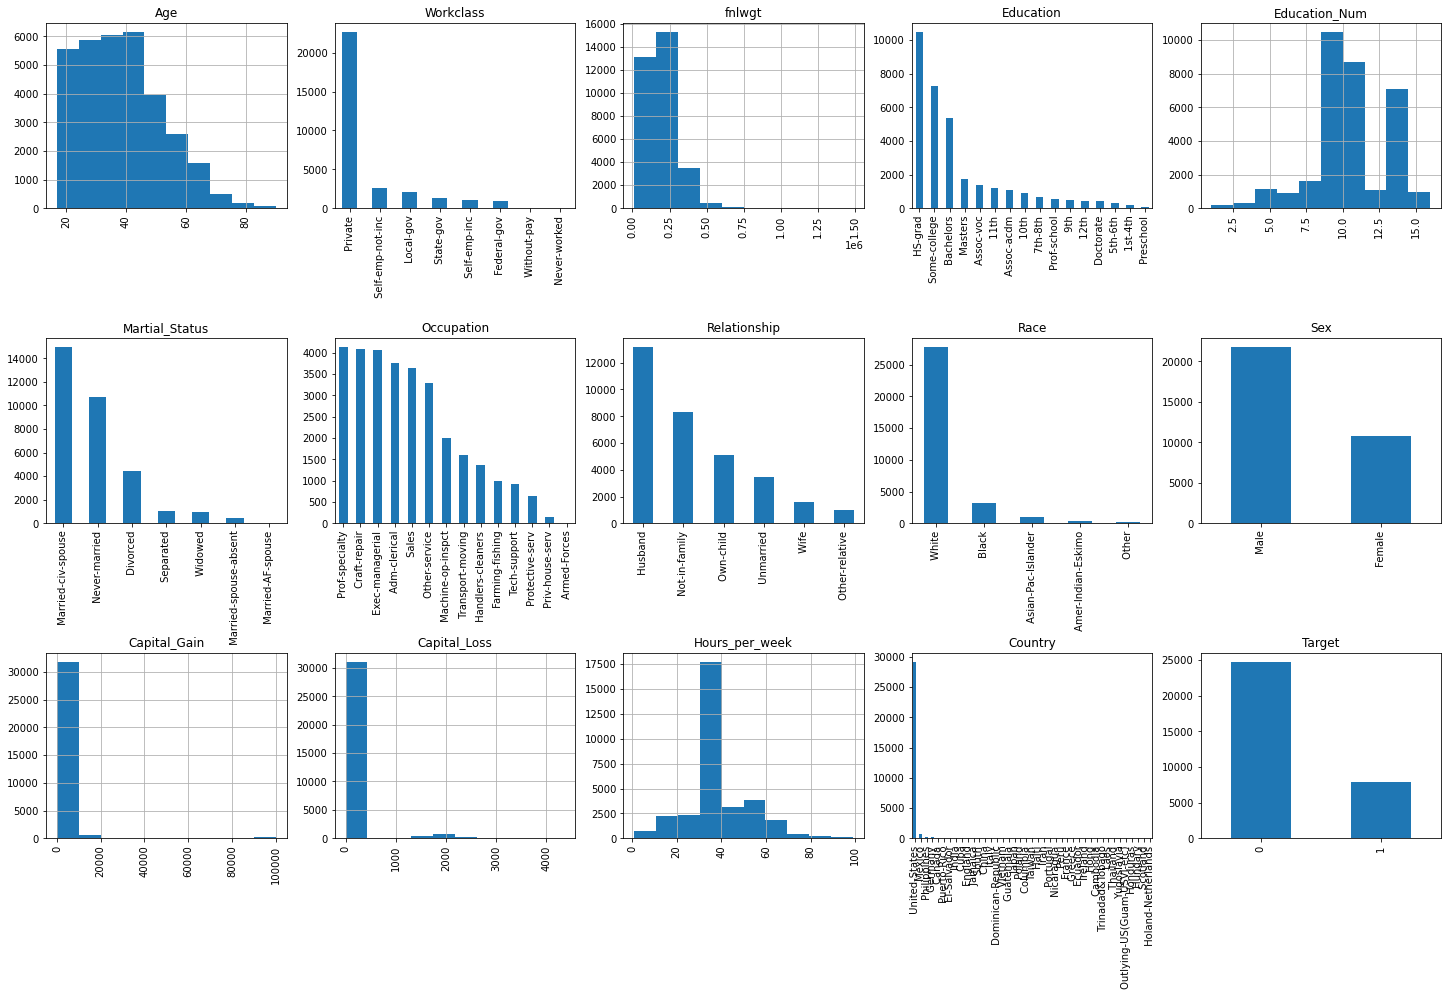

In [25]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2);

**Проверяем типы данных**

In [26]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [27]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [28]:
data_test["Age"] = data_test["Age"].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [29]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [30]:
# выделим в выборках категориальные и числовые поля

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name == "object"
]
numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [31]:
# заполним пропуски

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [32]:
data_train = pd.concat(
    [data_train[numerical_columns], pd.get_dummies(data_train[categorical_columns])],
    axis=1,
)

data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [33]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [34]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [35]:
data_test["Country_ Holand-Netherlands"] = 0

In [36]:
set(data_train.columns) - set(data_test.columns)

set()

In [37]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [38]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [39]:
X_train = data_train.drop(["Target"], axis=1)
y_train = data_train["Target"]

X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

## 3.1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [40]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

tree.fit(X_train, y_train);

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [41]:
tree_predictions = tree.predict(X_test)

In [42]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(y_test, tree_predictions)
accuracy_score

0.8447884036607088

<font color='red'>Вопрос 6.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

## 3.2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`. Проведите 5-кратную кросс-валидацию**

In [43]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, 
                                cv=5)                    

locally_best_tree.fit(X_train, y_train);

In [44]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565770273854106


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [45]:
from sklearn.metrics import accuracy_score

tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score = accuracy_score(y_test, tuned_tree_predictions)
accuracy_score

0.847798046803022

<font color='red'>Вопрос 7.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

## 3.3. Случайный лес без настройки параметров  (опционально)

**Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья.**

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`), число деревьев сделайте равным ста, а `random_state` = 17.**

In [46]:
rf = RandomForestClassifier(random_state=17)
rf.fit(X_train, y_train);

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [47]:
forest_predictions = rf.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(y_test, forest_predictions)
accuracy_score

0.8585467723112831

## 3.4. Случайный лес с настройкой параметров  (опционально)

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.**

In [49]:
forest_params = {'max_depth': range(10, 21, 5),
                'max_features': range(5, 105, 35)}

locally_best_forest = GridSearchCV(RandomForestClassifier(random_state=17), forest_params, n_jobs=-1)

locally_best_forest.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(10, 21, 5),
                         'max_features': range(5, 105, 35)})

In [50]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 15, 'max_features': 40}
Best cross validaton score 0.8642857264114749


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [51]:
from sklearn.metrics import accuracy_score

tuned_forest_predictions = locally_best_forest.predict(X_test)
accuracy_score = accuracy_score(y_test, tuned_forest_predictions)
accuracy_score

0.8653645353479515

Итоговый балл: 10/10.